# Build a Question/Answering system over SQL data
[LangChain](https://python.langchain.com/docs/tutorials/sql_qa/)

In [ ]:
!sudo apt update; sudo apt install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
!pip install langchain-core langchain-community langchain-openai langchainhub langgraph

In [1]:
import os, re, ast
from dotenv import load_dotenv
from typing_extensions import TypedDict, Annotated
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain import hub
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_community.callbacks import get_openai_callback
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.agents.agent_toolkits import create_retriever_tool

_ = load_dotenv()

In [2]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [3]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0)

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")
assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [4]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

# class QueryOutput(TypedDict):
#     """Generated SQL query."""

#     query: Annotated[str, ..., "Syntactically valid SQL query."]

# Replace for QueryOutput, when it cannot be used
output_parser = StructuredOutputParser.from_response_schemas([
    ResponseSchema(name="query", description="Syntactically valid SQL query.")
])

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )

    # structured_llm = llm.with_structured_output(QueryOutput)
    # result = structured_llm.invoke(prompt)

    format_prompt = f"{prompt}\n\n{output_parser.get_format_instructions()}"
    with get_openai_callback() as cb:
        result = output_parser.parse(llm.invoke(format_prompt).content)
        print(f"write_query node - cost: ${format(cb.total_cost, '.6f')}")
        print(f"write_query node - prompt tk: {cb.prompt_tokens}")
        print(f"write_query node - prompt tk cache: {cb.prompt_tokens_cached}")
        print(f"write_query node - compl tk: {cb.completion_tokens}")
        print(f"write_query node - total tk: {cb.total_tokens}")
        print()
    return {"query": result["query"]}

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    with get_openai_callback() as cb:
        response = llm.invoke(prompt)
        print(f"write_query node - cost: ${format(cb.total_cost, '.6f')}")
        print(f"write_query node - prompt tk: {cb.prompt_tokens}")
        print(f"write_query node - prompt tk cache: {cb.prompt_tokens_cached}")
        print(f"write_query node - compl tk: {cb.completion_tokens}")
        print(f"write_query node - total tk: {cb.total_tokens}")
        print()
    return {"answer": response.content}

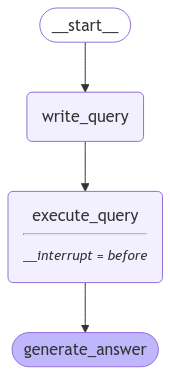

In [5]:
# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}
memory = MemorySaver()

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
for step in graph.stream(
    {"question": "How many employees are there?"}, config, stream_mode="updates"
):
    print("Stream step")
    print(step)
    print()

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print("Stream step")
        print(step)
        print()
else:
    print("Operation cancelled by user.")

write_query node - cost: $0.007841
write_query node - prompt tk: 2591
write_query node - prompt tk cache: 0
write_query node - compl tk: 17
write_query node - total tk: 2608

Stream step
{'write_query': {'query': 'SELECT COUNT(*) FROM Employee'}}

Stream step
{'__interrupt__': ()}

Stream step
{'execute_query': {'result': '[(8,)]'}}

write_query node - cost: $0.000174
write_query node - prompt tk: 50
write_query node - prompt tk cache: 0
write_query node - compl tk: 6
write_query node - total tk: 56

Stream step
{'generate_answer': {'answer': 'There are 8 employees.'}}



In [6]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
for tool in tools:
    print(type(tool), tool.description)

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

<class 'langchain_community.tools.sql_database.tool.QuerySQLDatabaseTool'> Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
<class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'> Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
<class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'> Input is an empty string, output is a comma-separated list of tables in the database.
<class 'langchain_community.tools.sql_database.tool.QuerySQLCheckerTool'> Use this tool to double check if yo

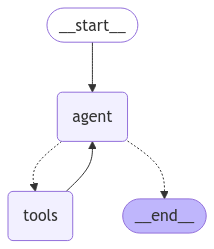

In [7]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)
agent_executor = create_react_agent(llm, tools, state_modifier=system_message)
agent_executor

In [19]:
questions = ["How many employees are there?",
             "Which country/'s customers spent the most?",
             "Describe the playlisttrack table",
             "How many albums does alis in chain have?",
             "Which sales agent made the most in sales in 2009?"]
answers = [8,
           ('USA', 523.06),
           'PlaylistTrack',
           1,
           ...]

def query_bot(agent, question: str):
    stream = agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
    )
    next(stream)["messages"][-1].pretty_print()

    conn = ''
    while conn == '':
        with get_openai_callback() as cb:
            try:
                next(stream)["messages"][-1].pretty_print()
        
                print(f"write_query node - cost: ${format(cb.total_cost, '.6f')}")
                print(f"write_query node - prompt tk: {cb.prompt_tokens}")
                print(f"write_query node - prompt tk cache: {cb.prompt_tokens_cached}")
                print(f"write_query node - compl tk: {cb.completion_tokens}")
                print(f"write_query node - total tk: {cb.total_tokens}")
                print()
            except StopIteration:
                break

        conn = input('Enter for continue')

In [10]:
query_bot(agent_executor, questions[0])

================================ Human Message =================================

How many employees are there?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_BbWvUUeSMQGBEtamYQjDR9hF)
 Call ID: call_BbWvUUeSMQGBEtamYQjDR9hF
  Args:
    query: SELECT COUNT(*) FROM employees
write_query node - cost: $0.001751
write_query node - prompt tk: 557
write_query node - prompt tk cache: 0
write_query node - compl tk: 20
write_query node - total tk: 577

================================= Tool Message =================================
Name: sql_db_query

Error: (sqlite3.OperationalError) no such table: employees
[SQL: SELECT COUNT(*) FROM employees]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
write_query node - cost: $0.000000
write_query node - prompt tk: 0
write_query node - prompt tk cache: 0
write_query node - compl tk: 0
write_query node - total tk: 0

================================== Ai Message ============

In [11]:
query_bot(agent_executor, questions[1])

================================ Human Message =================================

Which country/'s customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_wpdjrBSPQxy8sh0KEjCyPbRM)
 Call ID: call_wpdjrBSPQxy8sh0KEjCyPbRM
  Args:
    query: SELECT c.Country, SUM(i.Total) AS TotalSpent FROM customers c JOIN invoices i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1
write_query node - cost: $0.001896
write_query node - prompt tk: 560
write_query node - prompt tk cache: 0
write_query node - compl tk: 54
write_query node - total tk: 614

================================= Tool Message =================================
Name: sql_db_query

Error: (sqlite3.OperationalError) no such table: customers
[SQL: SELECT c.Country, SUM(i.Total) AS TotalSpent FROM customers c JOIN invoices i ON c.CustomerId = i.CustomerId GROUP BY c.Country ORDER BY TotalSpent DESC LIMIT 1]
(Background on

In [ ]:
# Failed to get the answer, not check the tables list
query_bot(agent_executor, questions[2])

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_oOFlIEPzXWlU34ecH4ljo8mH)
 Call ID: call_oOFlIEPzXWlU34ecH4ljo8mH
  Args:
    table_names: playlisttrack
write_query node - cost: $0.001740
write_query node - prompt tk: 556
write_query node - prompt tk cache: 0
write_query node - compl tk: 18
write_query node - total tk: 574

================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'playlisttrack'} not found in database
write_query node - cost: $0.000000
write_query node - prompt tk: 0
write_query node - prompt tk cache: 0
write_query node - compl tk: 0
write_query node - total tk: 0

================================== Ai Message ==================================

I'm sorry, but I couldn't find a table named "playlisttrack" in the database. Ple

In [20]:
def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
genres = query_as_list(db, "SELECT Name FROM Genre")

embeddings = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv("AZURE_OPENAI_EMB_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_EMB_API_KEY"),
    openai_api_version="2023-05-15"
)
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_texts(artists + albums + genres)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)
tools.append(retriever_tool)

# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"
agent = create_react_agent(llm, tools, state_modifier=system)

In [21]:
# Failed to get the answer, bad query
query_bot(agent, questions[3])

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_lk4uWJIbjxIpi8SOKfztw3vM)
 Call ID: call_lk4uWJIbjxIpi8SOKfztw3vM
  Args:
    query: alis in chain
write_query node - cost: $0.002102
write_query node - prompt tk: 674
write_query node - prompt tk cache: 0
write_query node - compl tk: 20
write_query node - total tk: 694

================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Alanis Morissette

Up An' Atom

Jagged Little Pill

A-Sides
write_query node - cost: $0.000000
write_query node - prompt tk: 0
write_query node - prompt tk cache: 0
write_query node - compl tk: 0
write_query node - total tk: 0

================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_wpdjrBSPQxy8sh0KE

In [ ]:
# Failed to get the answer, bad query
query_bot(agent, questions[4])

================================ Human Message =================================

Which sales agent made the most in sales in 2009?
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_wpdjrBSPQxy8sh0KEjCyPbRM)
 Call ID: call_wpdjrBSPQxy8sh0KEjCyPbRM
  Args:
    table_names: sales, agents
write_query node - cost: $0.002107
write_query node - prompt tk: 677
write_query node - prompt tk cache: 0
write_query node - compl tk: 19
write_query node - total tk: 696

================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'sales', 'agents'} not found in database
write_query node - cost: $0.000000
write_query node - prompt tk: 0
write_query node - prompt tk cache: 0
write_query node - compl tk: 0
write_query node - total tk: 0

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_2fW4RU10TUV6o45B8pwpPw5i